# Exam set 
## date : 19/01 - 2023


### Import of libraries and external functions

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
from scipy import stats
import math 
import sympy as sp
from IPython.core.display import Latex
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import sys

In [101]:
sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import  nice_string_output, add_text_to_ax 

In [102]:
sys.path.append('My_Functions')
from My_Functions import *
plot_pref()
r = np.random
r.seed(16)

## Problem 3 Simulation/ Monte Carlo

The mean fraction of containers that have to wait a day to be loaded on ship is:  0.1945344 +/- 0.0039116104918562634


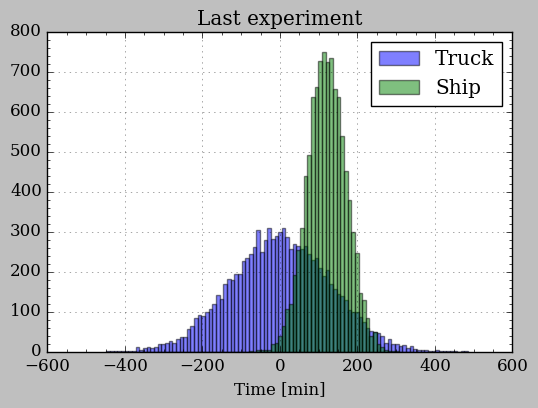

In [103]:
#3.1 
sTruck = 130
sShip = 50

#3.1.1
#if delta t = 130 what fraction of containers from truck have to wait a day to be loaded on ship?
dt = 120

#We simulate N points from each distribution of arrival/ departure times
N = 10000
#We repeat the experiment N_exp times 
N_exp = 1000

fractions = np.zeros(N_exp)

for i in range(N_exp):
    tTruck = r.normal(0, sTruck, N)
    tShip = r.normal(dt, sShip, N)

    #We then find the number of containers that have to wait a day to be loaded on ship
    wait = tTruck > tShip
    fractions[i] = np.sum(wait)/N

#We then find the mean and standard deviation of the fraction of containers that have to wait a day to be loaded on ship
mean = np.mean(fractions)
std = np.std(fractions)

print('The mean fraction of containers that have to wait a day to be loaded on ship is: ', mean, '+/-', std)

#plot the last experiment
bins = np.linspace(np.min(tTruck), np.max(tTruck), 100)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(tTruck, bins, alpha=0.5, label='Truck')
ax.hist(tShip, bins, alpha=0.5, label='Ship')
ax.legend(loc='upper right')
ax.set_xlabel('Time [min]')
ax.set_title('Last experiment')

#fig.savefig('figures/311experiment.png')

The optimal value for delta t is:  235.78969236394434
The error on the optimal value for delta t is:  18.50120197796417


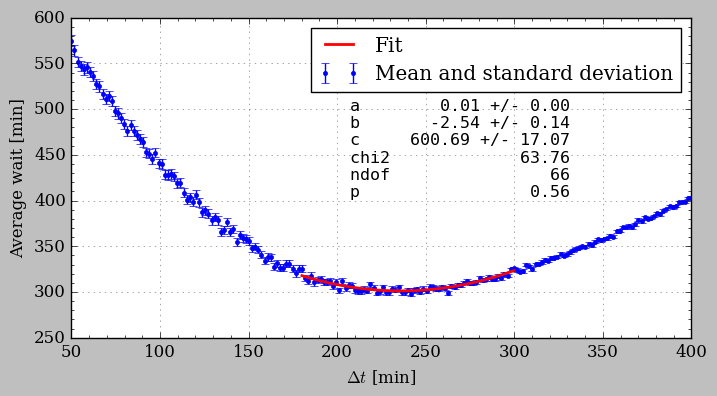

In [104]:
#3.1.2
#We find the optimal value for delta t 
dts = np.linspace(50, 400, 200)
means = np.zeros(len(dts))
unc = np.zeros(len(dts))
for i,t in enumerate(dts):
    tTruck = r.normal(0, sTruck, N)
    tShip = r.normal(t, sShip, N)

    #We then find the number of containers that have to wait a day to be loaded on ship
    wait = tShip - tTruck
    #add 24 hours to the time difference if the container has to wait a day to be loaded on ship
    wait[wait < 0] += 24*60
    means[i] = np.mean(wait)
    unc[i] = np.std(wait)/np.sqrt(N)

#We find the optimal value for delta t by fitting a parabola to the mean and standard deviation
#We fit between 200 and 300 min
slice = (dts > 180) & (dts < 300)
chi2_poly2 = Chi2Regression(poly2, dts[slice], means[slice], unc[slice])
minuit_poly2 = Minuit(chi2_poly2, a = 1, b= 0 , c = 0)
minuit_poly2.migrad();

#plot the mean and standard deviation as a function of delta t
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(dts[slice], poly2(dts[slice], *minuit_poly2.values), label='Fit', color='red', zorder = 1, linewidth=2)
ax.errorbar(dts, means, yerr=unc, fmt='.', label='Mean and standard deviation', zorder = 0)
ax.set_xlabel(r'$\Delta t$ [min]')
ax.set_ylabel('Average wait [min]')
ax.legend()

#From the fit we find the optimal value for delta t 
dt_opt = -minuit_poly2.values['b']/(2*minuit_poly2.values['a'])
print('The optimal value for delta t is: ', dt_opt)
#With errors found through error propagation
dt_opt_err = np.sqrt(1/(2*minuit_poly2.values['a']**2)*minuit_poly2.errors['b']**2 + 1/(4*minuit_poly2.values['a']**3)*minuit_poly2.errors['a']**2)
print('The error on the optimal value for delta t is: ', dt_opt_err)

chi2, ndof, p = evaluate_chi2(minuit_poly2, len(dts[slice]))

d = {
    'a': [minuit_poly2.values['a'], minuit_poly2.errors['a']],
    'b': [minuit_poly2.values['b'], minuit_poly2.errors['b']],
    'c': [minuit_poly2.values['c'], minuit_poly2.errors['c']],
    'chi2' : chi2,
    'ndof' : ndof,
    'p' : p
}
text = nice_string_output(d, extra_spacing=2, decimals=2)
add_text_to_ax(0.45, 0.75, text, ax, fontsize=12)

#fig.savefig('figures/312.png')


In [105]:
#3.2.1
#PDF given by the function
def Rayleigh(x, sigma, norm):
    return norm*x*np.exp(-x**2/(2*sigma**2))/(sigma**2)

print('Since the distribution is not bound in x we cannot use the acceptance-rejection method')
print('Since the distribution is invertible and normalized we can use the transformation method')


Since the distribution is not bound in x we cannot use the acceptance-rejection method
Since the distribution is invertible and normalized we can use the transformation method


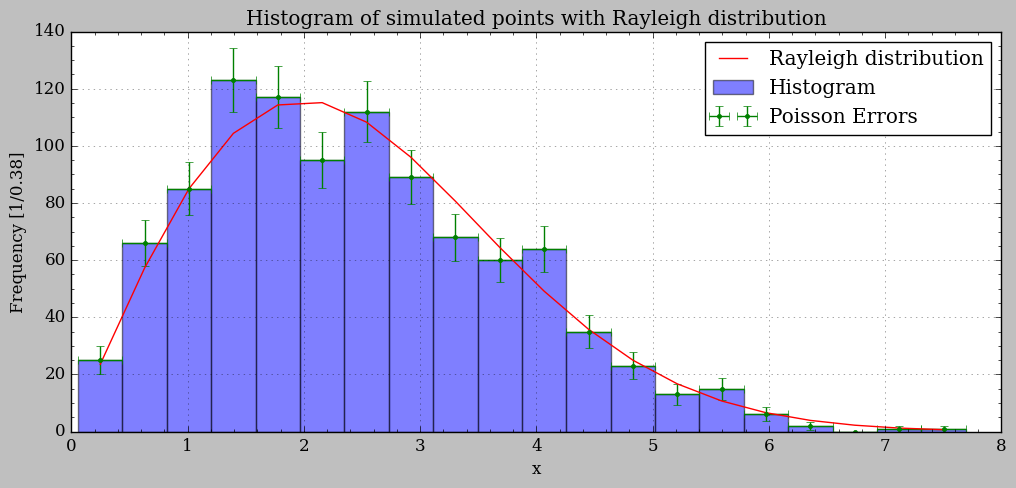

In [106]:
#We simulate N points from the distribution for sigma = 2
N = 1000

x = sp.symbols('x')
eq_pdf = (x/2**2)*sp.exp(-x**2/(2*2**2))
points = transform_method(eq_pdf, x, [0, sp.oo], N, r)*(-1)

#We plot the histogram of the simulated points
count, binedges, bincenters, binwidth = create_histogram(points, 20)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(points, bins=binedges, label='Histogram', alpha = 0.5)
ax.errorbar(bincenters, count, yerr=np.sqrt(count), xerr = binwidth/2, fmt='.', label='Poisson Errors', color='green')
ax.plot(bincenters, Rayleigh(bincenters, 2, N*binwidth), label='Rayleigh distribution', color='red')
ax.set_xlabel('x')
ax.set_ylabel(f'Frequency [1/{binwidth:.2f}]')
ax.set_title('Histogram of simulated points with Rayleigh distribution')
ax.legend()


#fig.savefig('figures/322.png')

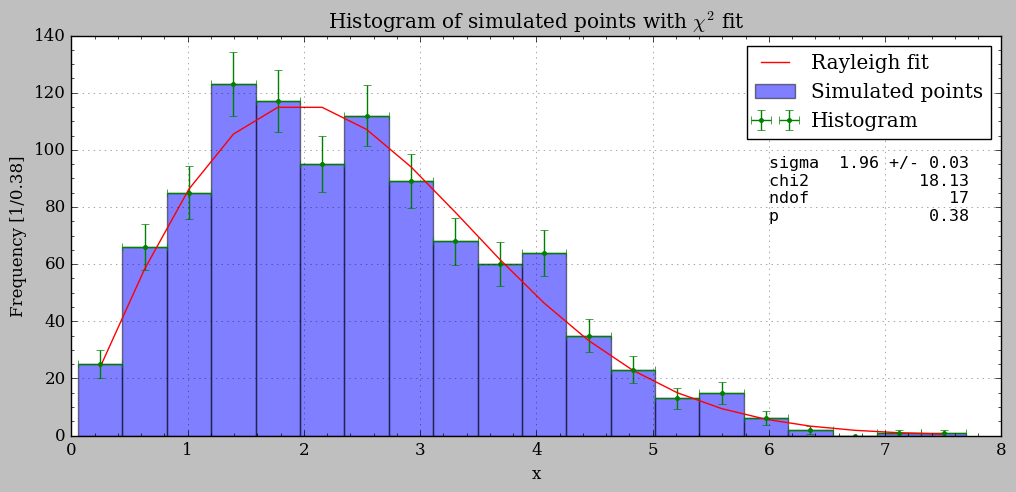

In [107]:
#3.2.3
#We now fit the distribution to the simulated points
#First we remove bins with 0 counts
mask = count > 0
count_fit = count[mask]
bincenters_fit = bincenters[mask]

chi2_Rayleigh = Chi2Regression(Rayleigh, bincenters_fit, count_fit, np.sqrt(count_fit))
minuit_Rayleigh = Minuit(chi2_Rayleigh, sigma = 1, norm = N*binwidth)
minuit_Rayleigh.migrad()

#We plot the fit 
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(points, bins=binedges, label='Simulated points', alpha = 0.5)
ax.errorbar(bincenters, count, yerr=np.sqrt(count), xerr = binwidth/2, fmt='.', label='Histogram', color='green')
ax.plot(bincenters, Rayleigh(bincenters, *minuit_Rayleigh.values), label='Rayleigh fit', color='red')
ax.set_xlabel('x')
ax.set_ylabel(f'Frequency [1/{binwidth:.2f}]')
ax.set_title(r'Histogram of simulated points with $\chi^2$ fit')
ax.legend()

chi2, ndof, p = evaluate_chi2(minuit_Rayleigh, len(count_fit))
d = {
    'sigma': [minuit_Rayleigh.values['sigma'], minuit_Rayleigh.errors['sigma']],
    'chi2': chi2,
    'ndof': ndof,
    'p': p,
}
text = nice_string_output(d, extra_spacing=2, decimals=2)
add_text_to_ax(0.75, 0.7, text, ax, fontsize=12)

#fig.savefig('figures/323_chi2.png')


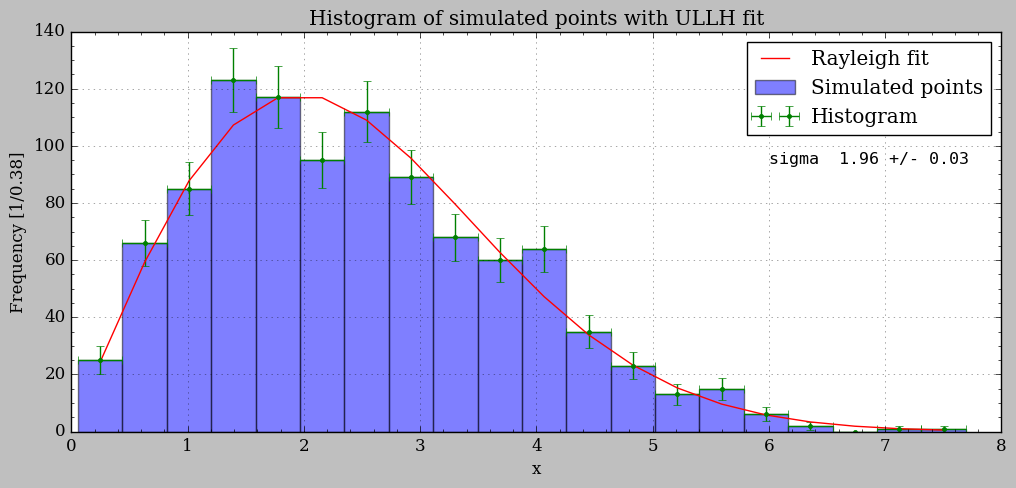

In [108]:
ullh_Rayleigh = UnbinnedLH(Rayleigh, points, bound=[0, np.max(points)], extended= True)
minuit_Rayleigh_ullh = Minuit(ullh_Rayleigh, sigma = 1, norm = 1)
minuit_Rayleigh_ullh.errordef = 0.5
minuit_Rayleigh_ullh.migrad()


fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(points, bins=binedges, label='Simulated points', alpha = 0.5)
ax.errorbar(bincenters, count, yerr=np.sqrt(count), xerr = binwidth/2, fmt='.', label='Histogram', color='green')
ax.plot(bincenters, Rayleigh(bincenters, minuit_Rayleigh_ullh.values[0], N*binwidth), label='Rayleigh fit', color='red')
ax.set_xlabel('x')
ax.set_ylabel(f'Frequency [1/{binwidth:.2f}]')
ax.set_title('Histogram of simulated points with ULLH fit')
ax.legend()

d = {
    'sigma': [minuit_Rayleigh_ullh.values['sigma'], minuit_Rayleigh_ullh.errors['sigma']],
}
text = nice_string_output(d, extra_spacing=2, decimals=2)
add_text_to_ax(0.75, 0.7, text, ax, fontsize=12)

#fig.savefig('figures/323_ullh.png')

In [109]:
#3.3.4
#We wish to test the 1/sqrt(N) nature of the error on sigma

Ns = np.arange(50, 5000, 10)
sigmas_chi2 = np.zeros(len(Ns))
sigmas_err_chi2 = np.zeros(len(Ns))

sigmas_ullh = np.zeros(len(Ns))
sigmas_err_ullh = np.zeros(len(Ns))

function_tran = transform_function(eq_pdf, x , [0, sp.oo])


for i, N in enumerate(Ns):
    points = function_tran( r.uniform(size = N))*(-1)
    count, binedges, bincenters, binwidth = create_histogram(points, 10)
    mask = count > 0
    count_fit = count[mask]
    bincenters_fit = bincenters[mask]
    chi2_Rayleigh = Chi2Regression(Rayleigh, bincenters_fit, count_fit, np.sqrt(count_fit))
    minuit_Rayleigh = Minuit(chi2_Rayleigh, sigma = 2, norm = N*binwidth)
    minuit_Rayleigh.migrad()
    sigmas_chi2[i] = minuit_Rayleigh.values['sigma']
    sigmas_err_chi2[i] = minuit_Rayleigh.errors['sigma']

    ullh_Rayleigh = UnbinnedLH(Rayleigh, points, bound=[0, np.max(points)], extended= True)
    minuit_Rayleigh_ullh = Minuit(ullh_Rayleigh, sigma = 2, norm = 1)
    minuit_Rayleigh_ullh.errordef = 0.5
    minuit_Rayleigh_ullh.migrad()
    sigmas_ullh[i] = minuit_Rayleigh_ullh.values['sigma']
    sigmas_err_ullh[i] = minuit_Rayleigh_ullh.errors['sigma']



In [110]:
#We define the function we wish to fit
def powerlaw(x, a, b):
    return a*x**b



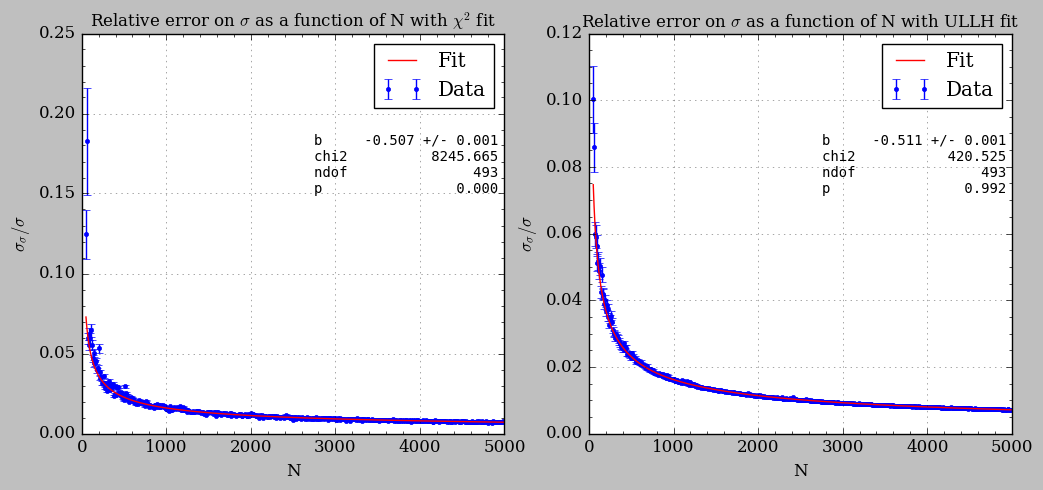

In [111]:
#We fit the relative error to get an uncertainty 
rel_err_chi2 = sigmas_err_chi2/sigmas_chi2
rel_err_ullh = np.abs(sigmas_err_ullh/sigmas_ullh)

#We fit the data
chi2_powerlaw = Chi2Regression(powerlaw, Ns, rel_err_chi2, rel_err_chi2**2)
minuit_powerlaw = Minuit(chi2_powerlaw, a = 1, b = -1/2)
minuit_powerlaw.migrad()

chi2_powerlaw_ullh = Chi2Regression(powerlaw, Ns, rel_err_ullh, rel_err_ullh**2)
minuit_powerlaw_ullh = Minuit(chi2_powerlaw_ullh, a = 1, b = -1/2)
minuit_powerlaw_ullh.migrad()

#We plot the data and the fit
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].errorbar(Ns, rel_err_chi2, yerr=rel_err_chi2**2, fmt='.', label='Data', color='blue', zorder= 0)
ax[0].plot(Ns, powerlaw(Ns, *minuit_powerlaw.values), label='Fit', color='red')
ax[0].set_xlabel('N')
ax[0].set_ylabel(r'$\sigma_\sigma / \sigma$')
ax[0].set_title(r'Relative error on $\sigma$ as a function of N with $\chi^2$ fit', fontsize=12)
ax[0].legend()

chi2, ndof, p = evaluate_chi2(minuit_powerlaw, len(Ns))
d = {
    'b': [minuit_powerlaw.values['b'], minuit_powerlaw.errors['b']],
    'chi2': chi2,
    'ndof': ndof,
    'p': p
}
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.55, 0.75, text, ax[0], fontsize=10)

ax[1].errorbar(Ns, rel_err_ullh, yerr=rel_err_ullh**2, fmt='.', label='Data', color='blue', zorder= 0)
ax[1].plot(Ns, powerlaw(Ns, *minuit_powerlaw_ullh.values), label='Fit', color='red', zorder= 1)
ax[1].set_xlabel('N')
ax[1].set_ylabel(r'$\sigma_\sigma / \sigma$')
ax[1].set_title(r'Relative error on $\sigma$ as a function of N with ULLH fit', fontsize=12)
ax[1].legend()

chi2_2, ndof_2, p_2 = evaluate_chi2(minuit_powerlaw_ullh, len(Ns))

d2 = {
    'b': [minuit_powerlaw_ullh.values['b'], minuit_powerlaw_ullh.errors['b']],
    'chi2': chi2_2,
    'ndof': ndof_2,
    'p': p_2
}
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.55, 0.75, text2, ax[1], fontsize=10)

#fig.savefig('figures/324.png')